This notebook is supposed to be similar to the other analyze xgboost, but takes into account all gene importances, not just the top three and the last as in `analyze_xgboost_binary_gain.ipynb`

In [37]:
import pandas as pd
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import os
from glob import glob
from matplotlib.colors import SymLogNorm
from scipy.cluster.hierarchy import linkage, leaves_list
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.obo_parser import GODag	
from opentree import OT


data = "2009"

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

#path = '/pfs/work7/workspace/scratch/tu_kmpaj01-link'
path = '../../'

In [38]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"{path}/xgboost/annotations{data}/*.pkl")]

In [39]:
ip2go = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/interpro2go", sep="\t", skiprows=5, header=None, names=["raw"])
ip2go[['InterPro', 'Description', 'GO_description',"GO_id"]] = ip2go['raw'].str.extract(r'InterPro:(IPR\d+)\s+(.+?)\s+>\s+GO:(.+)\s;\s(.+)')
ip2go.drop(columns=['raw'], inplace=True)
ip2go["Description"] = ip2go["Description"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

### Read in the data

In [40]:
with open(f"{path}/xgboost/annotations{data}/binary/binary.pkl", 'rb') as f:
	d = pickle.load(f)

In [5]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			importance_values = s.sort_values(ascending=False).values
			genes = s.sort_values(ascending=False).index.to_list()
			importance_ranking = s.sort_values(ascending=False).rank(ascending=False).values
			accuracy = d[rel][i][1]
			ner = d[rel][i][0][0]
			for j in range(len(importance_values)):
				l.append([rel, ner,genes[j], importance_values[j], importance_ranking[j],accuracy])


100%|██████████| 17/17 [00:42<00:00,  2.50s/it]


In [6]:
df = pd.DataFrame(l, columns=["rel","ner","gene","importance_values","importance_ranking","accuracy"])

### GO enrichment

In [7]:
# Load GO ontology
obo_filepath = os.path.join(os.getcwd(), "go-basic.obo")
if not os.path.exists(obo_filepath):
    !wget http://purl.obolibrary.org/obo/go/go-basic.obo
obo_dag = GODag("go-basic.obo")

# Create a dictionary mapping genes to GO terms
gene_to_go = {}
for _, row in ip2go.iterrows():
    gene = row['Description']
    go_id = row['GO_id']
    if gene not in gene_to_go:
        gene_to_go[gene] = set()
    gene_to_go[gene].add(go_id)

# Get all genes (population)
population = set(df['gene'].unique())

# Perform GO enrichment for each unique rel
go_enrichment_results = []

for rel in df['rel'].unique():
    # Get study genes (genes specific to this rel)
    study_genes = set(df[df['rel'] == rel]['gene'].unique())
    
    # Create GOEnrichmentStudy object
    g = GOEnrichmentStudy(
        population,
        gene_to_go,
        obo_dag,
        propagate_counts=False,
        alpha=0.05,
        methods=['fdr_bh']
    )
    
    # Run GO enrichment analysis
    go_results = g.run_study(study_genes)
    
    # Store results
    for r in go_results:
        if r.p_fdr_bh < 0.05:  # Only consider statistically significant results
            go_enrichment_results.append({
                'rel': rel,
                'go_id': r.GO,
                'go_term': r.name,
                'p_value': r.p_uncorrected,
                'p_fdr_bh': r.p_fdr_bh,
                'enrichment': r.enrichment,
                'study_count': r.study_count,
                'study_n': r.study_n,
                'pop_count': r.pop_count,
                'pop_n': r.pop_n,
                'depth': r.depth
            })

# Convert results to DataFrame
go_enrichment_df = pd.DataFrame(go_enrichment_results)

# Sort and display results
go_enrichment_df = go_enrichment_df.sort_values(['rel', 'p_fdr_bh'])

# Optionally, save results to a CSV file
#go_enrichment_df.to_csv("go_enrichment_results.csv", index=False)

go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms

Load  Ontology Enrichment Analysis ...
 22%  2,638 of 12,171 population items found in association

Runing  Ontology Analysis: current study set of 2610 IDs.
 32%    827 of  2,610 study items found in association
100%  2,610 of  2,610 study items found in population(12171)
Calculating 1,520 uncorrected p-values using fisher_scipy_stats
   1,520 terms are associated with  2,638 of 12,171 population items
     590 terms are associated with    827 of  2,610 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
     320 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Load  Ontology Enrichment Analysis ...
 22%  2,638 of 12,171 population items found in association

Runing  Ontology Analysis: current study set of 7129 IDs.
 26%  1,841 of  7,129 study items found in association
100%  7,12

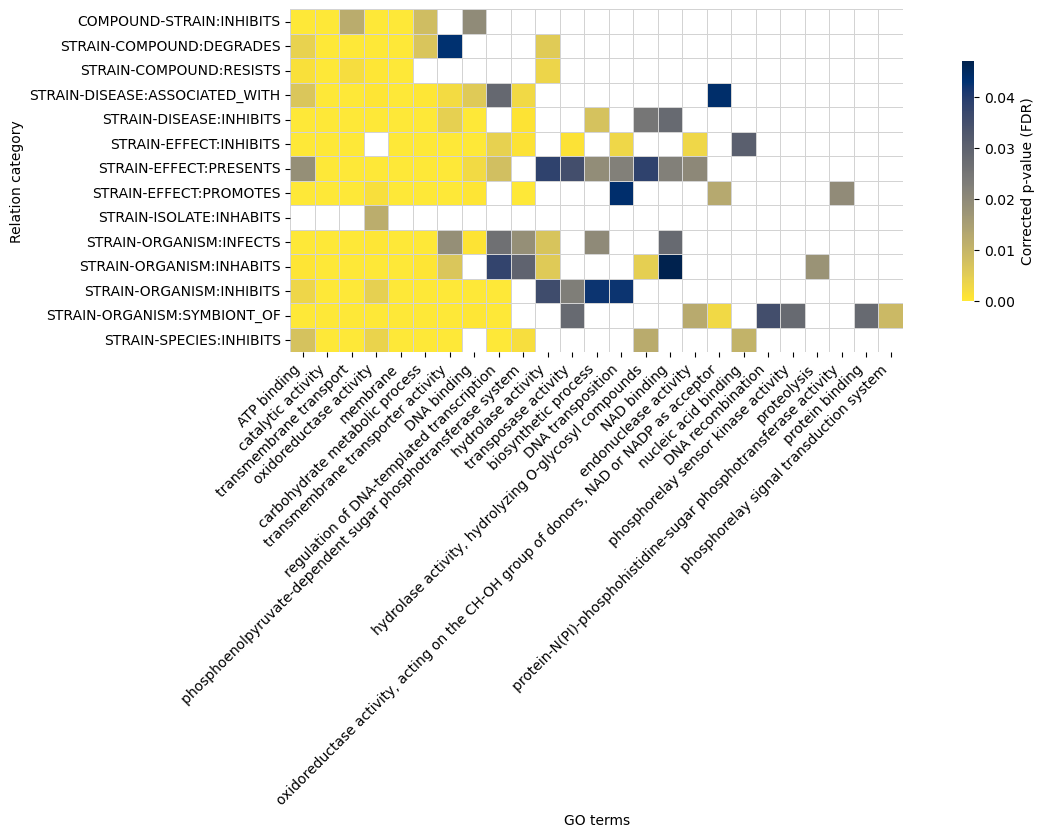

In [13]:
# Pivot the dataframe to create a matrix
pivot_df = go_enrichment_df[go_enrichment_df["enrichment"]=="e"].pivot(index='rel', columns='go_term', values='p_fdr_bh')

# Replace NaN values with 1 (least significant p-value)
pivot_df = pivot_df.fillna(1)

# Order the GO terms by the number of rels they are significant in
go_term_order = pivot_df.apply(lambda x: (x <= 0.05).sum(), axis=0).sort_values(ascending=False).index
pivot_df = pivot_df[go_term_order]

# Create a mask for p-values > 0.05 (not significant)
mask = pivot_df > 0.05

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_df, 
            cmap='cividis_r',
            mask=mask,  # Mask non-significant values
            cbar_kws={'label': 'Corrected p-value (FDR)', 'shrink': 0.7},  # Make the color bar smaller
            xticklabels=True,
            yticklabels=True,
            square=True, 
            linewidths=0.5,
            linecolor="lightgrey")  # Draw the grid

#plt.title('GO Term Enrichment Significance by Relation Type')
plt.xlabel('GO terms')
plt.ylabel('Relation category')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("figures/xgboost/xgboost_go_enrichment.pdf", bbox_inches="tight")

In [14]:
df[df["importance_ranking"]==1].value_counts("rel")

rel
STRAIN-MEDIUM:GROWS_ON            1775
STRAIN-COMPOUND:PRODUCES          1573
COMPOUND-STRAIN:INHIBITS          1275
STRAIN-PHENOTYPE:PRESENTS         1221
STRAIN-ISOLATE:INHABITS            996
STRAIN-COMPOUND:RESISTS            445
STRAIN-DISEASE:INHIBITS            347
STRAIN-COMPOUND:DEGRADES           336
STRAIN-ORGANISM:INFECTS            321
STRAIN-DISEASE:ASSOCIATED_WITH     248
STRAIN-ORGANISM:INHABITS           220
STRAIN-EFFECT:PRESENTS             143
STRAIN-EFFECT:PROMOTES             137
STRAIN-EFFECT:INHIBITS              90
STRAIN-ORGANISM:SYMBIONT_OF         80
STRAIN-ORGANISM:INHIBITS            75
STRAIN-SPECIES:INHIBITS             68
Name: count, dtype: int64

In [15]:
df.sort_values("importance_values")

,rel,ner,gene,importance_values,importance_ranking,accuracy
642601,STRAIN-COMPOUND:PRODUCES,coq_10,Protein of unknown function DUF4432,0.000001,106.0,0.999796
409004,COMPOUND-STRAIN:INHIBITS,cz,Biotin/lipoyl attachment,0.000001,53.0,0.999773
412468,COMPOUND-STRAIN:INHIBITS,bhib,"Beta-ketoacyl synthase-like, N-terminal",0.000001,32.0,0.999773
411404,COMPOUND-STRAIN:INHIBITS,thymine,"Beta-ketoacyl synthase-like, N-terminal",0.000001,32.0,0.999773
401426,COMPOUND-STRAIN:INHIBITS,bsn 37,"Polyketide synthase, C-terminal extension",0.000001,46.0,0.999659
...,...,...,...,...,...,...
1313532,STRAIN-EFFECT:INHIBITS,binding,"Uncharacterised protein family, inner membrane...",308.038940,1.0,0.996178
677679,STRAIN-PHENOTYPE:PRESENTS,gram positive,"GTP-binding protein OBG, C-terminal",318.645508,1.0,0.972356
1074760,STRAIN-MEDIUM:GROWS_ON,pbs t,Omega transcriptional repressor,362.347351,1.0,0.999948
678948,STRAIN-PHENOTYPE:PRESENTS,probiotic,Peptidase C69,475.549072,1.0,0.983452


### Write files for analysis

In [16]:
df[(df["ner"]!= "c")&(df["ner"]!= "l-")].sort_values("importance_values",ascending=False).to_csv("xgboost_files/gene_importances.csv",index=False)

In [17]:
# write file for figure with importance values higher than 20
df[(df["ner"]!= "c")&(df["ner"]!= "l-")&(df["importance_values"] > 20)].sort_values("importance_values",ascending=False).loc[:,["rel","ner","gene","importance_values","accuracy","importance_ranking"]].round({"importance_values": 2, "accuracy": 2}).to_excel("xgboost_files/gene_importances_high.xlsx",index=False)

In [18]:
df[(df["rel"]== "STRAIN-ORGANISM:INFECTS")].sort_values("importance_values",ascending=False).to_csv("xgboost_files/gene_importances_infects.csv",index=False)

In [19]:
# write file for figure with importance values higher than 20 for infects only
df[(df["rel"]== "STRAIN-ORGANISM:INFECTS")&(df["importance_values"] > 10)].sort_values("importance_values",ascending=False).loc[:,["ner","gene","importance_values","accuracy","importance_ranking"]].round({"importance_values": 2, "accuracy": 2}).to_excel("xgboost_files/gene_importances_high_infects.xlsx",index=False)

### Host association

In [20]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-SPECIES:INHIBITS,s. aureus,"Teichoic acid transporter subunit TagH, SH3-li...",51.811066,1.0,0.896243
1,STRAIN-SPECIES:INHIBITS,s. aureus,"4Fe-4S ferredoxin-type, iron-sulphur binding d...",26.990725,2.0,0.896243
2,STRAIN-SPECIES:INHIBITS,s. aureus,Na(+)/H(+) antiporter subunit F-like,24.346882,3.0,0.896243
3,STRAIN-SPECIES:INHIBITS,s. aureus,Sublancin immunity protein SunI,15.752762,4.0,0.896243
4,STRAIN-SPECIES:INHIBITS,s. aureus,Na+/H+ antiporter MnhB subunit-related protein,14.055265,5.0,0.896243
...,...,...,...,...,...,...
1320468,STRAIN-EFFECT:INHIBITS,pro inflammatory cytokine production,Glycoside hydrolase family 3 C-terminal domain,0.006337,55.0,0.997452
1320469,STRAIN-EFFECT:INHIBITS,pro inflammatory cytokine production,Major facilitator superfamily,0.005259,56.0,0.997452
1320470,STRAIN-EFFECT:INHIBITS,pro inflammatory cytokine production,"Glycosyl hydrolase family 59, catalytic domain",0.004748,57.0,0.997452
1320471,STRAIN-EFFECT:INHIBITS,pro inflammatory cytokine production,Proteasome assembly chaperone 2,0.004281,58.0,0.997452


In [21]:
oi = df[df["rel"]=="STRAIN-ORGANISM:INHABITS"]

In [22]:
common_genes = df.groupby("ner")["gene"].apply(set).reset_index()
common_genes = common_genes[common_genes["ner"].duplicated(keep=False)]

In [23]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

# Apply importance cutoff
importance_cutoff = 15
filtered_oi = filtered_oi[filtered_oi['importance_values'] > importance_cutoff]
filtered_oi.ner.unique()

/scratch/slurm_tmpdir/job_24614555/ipykernel_586609/2050756632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato")


array(['human', 'mouse', 'chicken', 'pig', 'tomato', 'rice', 'dog',
       'maize', 'rat', 'potato', 'murine', 'fish', 'arabidopsis',
       'soybean', 'flies', 'laying hens', 'rubber tree',
       'plasmodium falciparum', '31', 'gf mouse', 'yeast', 'free mouse',
       'canine', 'rainbow trout', 'rodents', 'shrimp', 'tick', 'alfalfa',
       't', 'equine', 'wild rodents', 'i. ricinus', 'crabs',
       'hymenoptera', 'green'], dtype=object)

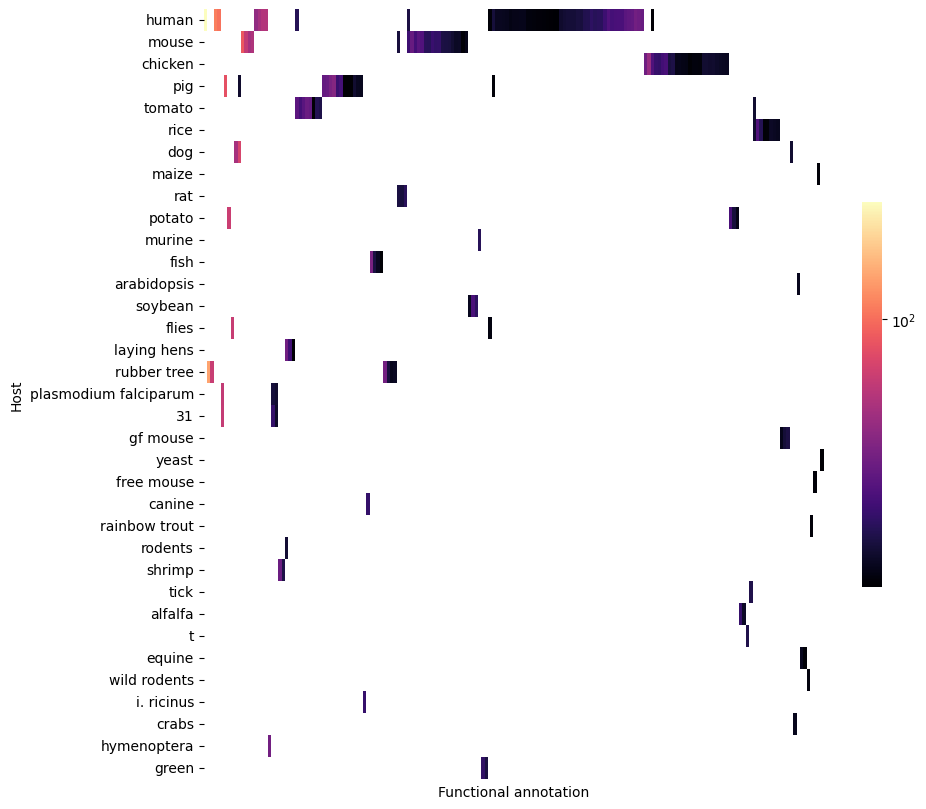

In [24]:
genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Drop all columns with no values
heatmap_data = heatmap_data.dropna(how='all', axis=1)

# Specify the order of organisms
#order_ner = ["potato", "tomato", "rice", "wheat", "maize","mouse","sheep", "cattle", "piglet","pig", "dog", "chicken"]
order_ner = ['human', 'mouse', 'chicken', 'pig', 'tomato', 'rice', 'dog',
       'maize', 'rat', 'potato', 'murine', 'fish', 'arabidopsis',
       'soybean', 'flies', 'laying hens', 'rubber tree',
       'plasmodium falciparum', '31', 'gf mouse', 'yeast', 'free mouse',
       'canine', 'rainbow trout', 'rodents', 'shrimp', 'tick', 'alfalfa',
       't', 'equine', 'wild rodents', 'i. ricinus', 'crabs',
       'hymenoptera', 'green']

# Reorder heatmap_data to match the specified order of organisms
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Remove genes that are all na
ordered_genes = ordered_genes[~heatmap_data[ordered_genes].isna().all()]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Create the heatmap with log color mapping
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar=True, xticklabels=False, cbar_kws={'shrink': 0.5}, norm=SymLogNorm(linthresh=0.01))

plt.ylabel('Host')
plt.xlabel('Functional annotation')
plt.savefig("figures/xgboost/xgboost_heatmap_cluster_inhabits.pdf", bbox_inches="tight")

/scratch/slurm_tmpdir/job_24614555/ipykernel_586609/990964657.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,15))


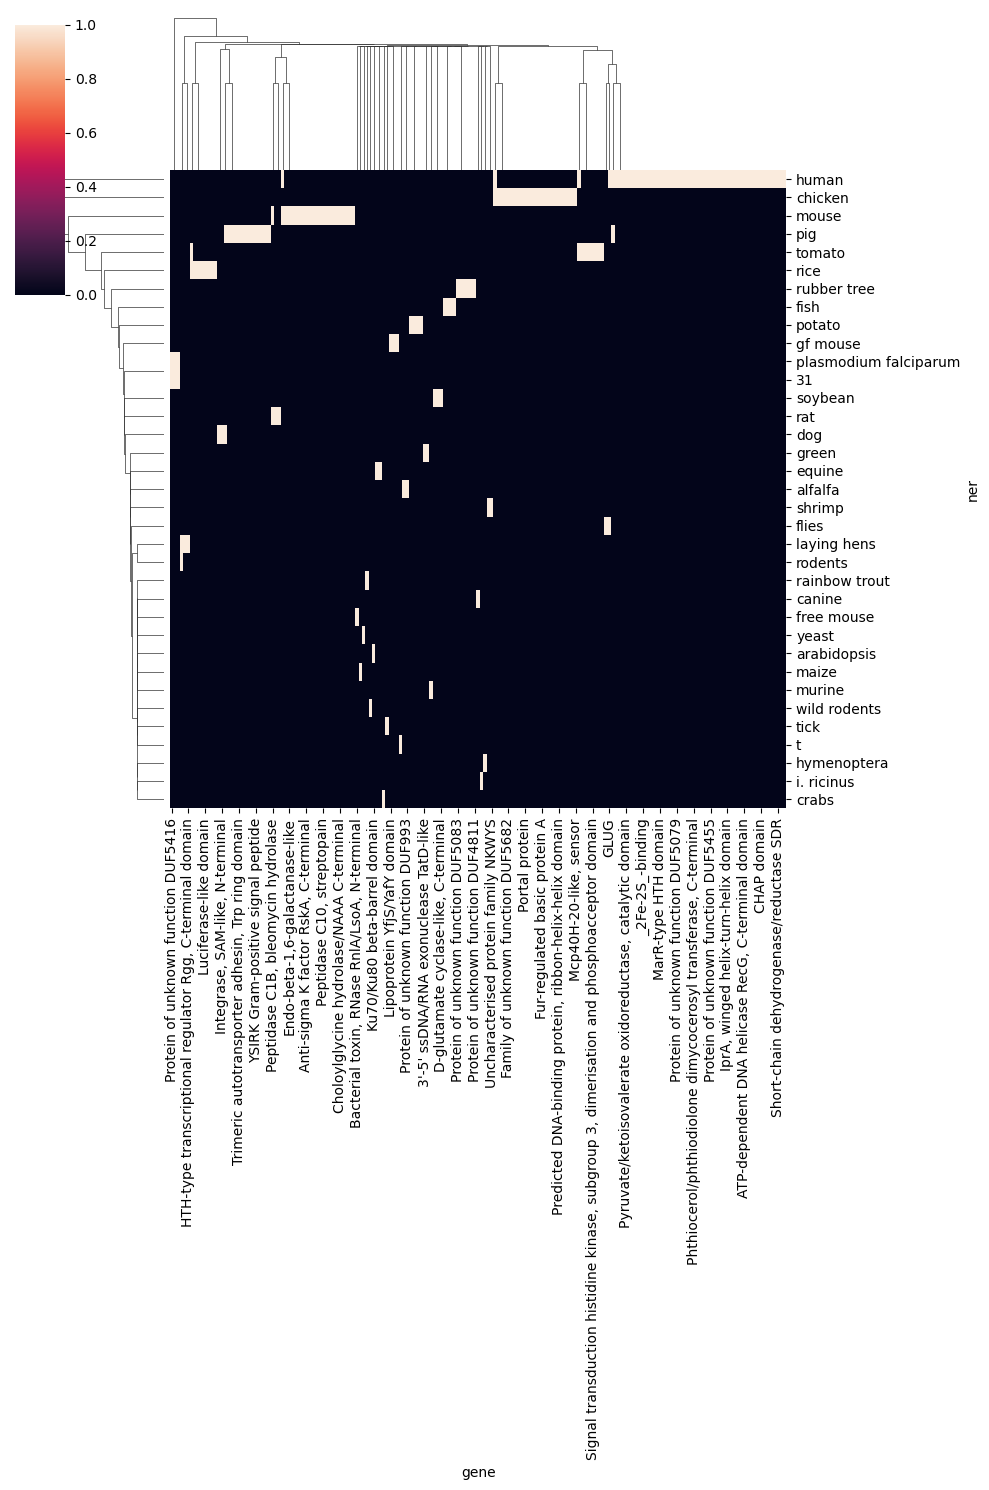

In [26]:
sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,15))

#### Instead of setting a cutoff get the top 5 genes for each host

In [34]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato").replace("equine","horse").replace("porcine","pig").replace("poplar tree","poplar").replace("equus caballus","horse").replace("tomato seedlings","tomato").replace("tomatoes","tomato").replace("cows","cow").replace("broilers","chicken").replace("laying hens","chicken").str.replace("piglet","pig").replace("broiler chickens","chicken").replace("chicks","chicken").replace("healthy volunteers","human").replace("healthy human","human").replace("healthy human subjects","human").replace("swine","pig").replace("pigs","pig").replace("canine","dog").replace("bovine","cow").replace("cattle","cow").replace("rice plants","rice").replace("rice seedlings","rice").replace("wild birds","bird").replace("a. thaliana","arabidopsis thaliana").replace("arabidopsis","arabidopsis thaliana").replace("healthy adults", "human").replace("avian","bird").replace("human volunteers","human").str.replace("germ-free mouse", "mouse").replace("gnotobiotic mice", "mouse").replace("c57bl/6 mice", "mouse").replace("balb/c mice", "mouse").replace("arabidopsis plants", "arabidopsis thaliana").replace("volunteers", "human").replace("a. melifera", "honeybee").replace("children","human").replace("infant","human").str.replace("horses","horse").replace("sponges","sponge",).replace("cats","cat").str.replace("o. sativa","rice").replace("corn", "maize").str.replace("cats", "cat").replace("infants","human").replace("human patient","human").replace("preterm infants", "human").replace('a. mellifera',"honeybee").replace("potato plants", "potato").str.replace("calf","cow").str.replace("populus tree","poplar").str.replace("ticks","tick").str.replace("worms","worm").str.replace("nematodes","worm").replace("wild rodents","rodents").replace("drosophila","d. melanogaster").replace("murine","mice").replace("germ-free mice","mice").replace("mice","mouse").replace("galleria mellonella larvae","galleria mellonella").replace("c57bl/6","mouse").replace("gf mouse", "mouse").replace("free mouse", "mouse").replace("sugar cane","sugarcane")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant","p. falciparum","caco-2","animal","seedlings","t","animals", "plasmodium falciparum","3d7","mammalian","fungi","larvae","livestock","d. discoideum","fungal","tree","mosquito","tick","sponge","yeast","31","flies","green","dairy"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

# Select top 3 genes for each host with importance values higher than 10
filtered_oi = filtered_oi[filtered_oi['importance_values'] > 10]
filtered_oi = filtered_oi.sort_values(by='importance_values', ascending=False).groupby('ner').head(3)
filtered_oi.ner.unique()

/scratch/slurm_tmpdir/job_24614555/ipykernel_586609/3126480633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato").replace("equine","horse").replace("porcine","pig").replace("poplar tree","poplar").replace("equus caballus","horse").replace("tomato seedlings","tomato").replace("tomatoes","tomato").replace("cows","cow").replace("broilers","chicken").replace("laying hens","chicken").str.replace("piglet","pig").replace("broiler chickens","chicken").replace("chicks","chicken").replace("healthy volunteers","human").replace("healthy human","human").replace("healthy human subjects","human").replace("swine","pig").replace("pi

array(['human', 'rubber tree', 'mouse', 'pig', 'dog', 'potato', 'chicken',
       'fish', 'hymenoptera', 'shrimp', 'tomato', 'rice', 'soybean',
       'alfalfa', 'i. ricinus', 'rat', 'rodents', 'horse', 'crabs',
       'arabidopsis thaliana', 'rainbow trout', 'maize', 'wheat',
       'citrus', 'iberian ibex', 'atlantic salmon', 'cow', 'dairy',
       'sheep', 'sugar', 'apis mellifera', 'sugar beet', 'worm',
       'catfish', 'caenorhabditis elegans', 'sugarcane', 'goat',
       'beta vulgaris', 'n. viridula', 'photinia frasery', 'cucumber',
       'melon', 'fruit fly', 'tobacco', 'galleria mellonella', 'poplar',
       'zebrafish', 'ulva lactuca', 'pepper', 'cat'], dtype=object)

The part below is generated by ChatGPT

In [35]:
taxonomic_ranks_inhabits = {
    'human': 'Homo sapiens',  # Species
    'rubber tree': 'Hevea brasiliensis',  # Species
    'mouse': 'Mus musculus',  # Species
    'pig': 'Sus scrofa',  # Species
    'dog': 'Canis lupus familiaris',  # Subspecies
    'potato': 'Solanum tuberosum',  # Species
    'chicken': 'Gallus gallus',  # Species
    'fish': 'Pisces',  # Superclass
    'hymenoptera': 'Hymenoptera',  # Order
    'shrimp': 'Caridea',  # Infraorder
    'tomato': 'Solanum lycopersicum',  # Species
    'rice': 'Oryza sativa',  # Species
    'soybean': 'Glycine max',  # Species
    'alfalfa': 'Medicago sativa',  # Species
    'i. ricinus': 'Ixodes ricinus',  # Species (Tick)
    'rat': 'Rattus norvegicus',  # Species
    'rodents': 'Rodentia',  # Order
    'horse': 'Equus ferus caballus',  # Subspecies
    'crabs': 'Brachyura',  # Infraorder
    'arabidopsis thaliana': 'Arabidopsis thaliana',  # Species
    'rainbow trout': 'Oncorhynchus mykiss',  # Species
    'maize': 'Zea mays',  # Species
    'wheat': 'Triticum aestivum',  # Species
    'citrus': 'Citrus',  # Genus
    'iberian ibex': 'Capra pyrenaica',  # Species
    'atlantic salmon': 'Salmo salar',  # Species
    'cow': 'Bos taurus',  # Species
    'dairy': 'Bos taurus',  # Species (Common in dairy cattle)
    'sheep': 'Ovis aries',  # Species
    'sugar': 'Saccharum',  # Genus (Relating to sugarcane)
    'apis mellifera': 'Apis mellifera',  # Species (Honey bee)
    'sugar beet': 'Beta vulgaris',  # Species
    'worm': 'Annelida',  # Phylum (General term for segmented worms)
    'catfish': 'Siluriformes',  # Order
    'caenorhabditis elegans': 'Caenorhabditis elegans',  # Species
    'sugarcane': 'Saccharum officinarum',  # Species
    'goat': 'Capra hircus',  # Species
    'beta vulgaris': 'Beta vulgaris',  # Species
    'n. viridula': 'Nezara viridula',  # Species (Green stink bug)
    'photinia frasery': 'Photinia × fraseri',  # Hybrid Species
    'cucumber': 'Cucumis sativus',  # Species
    'melon': 'Cucumis melo',  # Species
    'fruit fly': 'Drosophila melanogaster',  # Species
    'tobacco': 'Nicotiana tabacum',  # Species
    'galleria mellonella': 'Galleria mellonella',  # Species
    'poplar': 'Populus',  # Genus
    'zebrafish': 'Danio rerio',  # Species
    'ulva lactuca': 'Ulva lactuca',  # Species (Sea lettuce)
    'pepper': 'Capsicum',  # Genus
    'cat': 'Felis catus',  # Species
}

In [36]:
fi = list(taxonomic_ranks_inhabits.values())

ott_ids = {}
for name in fi:
    ott_id = OT.get_ottid_from_name(name)
    if ott_id is not None:
        ott_ids[ott_id] = name

# Remove problematic OTT IDs
ott_ids_filtered = {ott_id: name for ott_id, name in ott_ids.items() if ott_id not in [3904118, 5602399, 5673746]}

# Generate the synthetic tree with filtered OTT IDs
output = OT.synth_induced_tree(ott_ids=list(ott_ids_filtered.keys()), label_format='id')

output.tree.print_plot(width=100)

OTWebServicesError: Call to tree_of_life/induced_subtree failed with the message "[/v3/tree_of_life/induced_subtree] Error: node_id 'ott3903589' was not found!
Full list of unknown/unrecognized query ids:
 ott3903589 
"

In [ ]:
# Get the leaf nodes from the tree
leaf_nodes = [ott_ids_filtered[int(leaf.taxon.label.replace('ott', '').replace('mrca', ''))] for leaf in output.tree.leaf_node_iter() if not leaf.taxon.label.startswith('mrca')]


In [ ]:
order_ner = [next(key for key, value in taxonomic_ranks_inhabits.items() if value == name) if name in taxonomic_ranks_inhabits.values() else name for name in leaf_nodes]

In [ ]:
import matplotlib.gridspec as gridspec
from Bio import Phylo
from io import StringIO

genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Drop all columns with no values
heatmap_data = heatmap_data.dropna(how='all', axis=1)

# Reorder heatmap_data to match the specified order of organisms
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Remove genes that are all na
ordered_genes = ordered_genes[~heatmap_data[ordered_genes].isna().all()]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Identify columns with more than 1 value
columns_with_multiple_values = heatmap_data.count()[heatmap_data.count() > 1].index

# Create a figure with two subplots
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[.5, 4.5])  # Increased width ratio for the tree

# Plot the tree on the left
ax0 = plt.subplot(gs[0])
phylo_tree = Phylo.read(StringIO(output.tree.as_string(schema="newick")), "newick")
Phylo.draw(phylo_tree, axes=ax0, do_show=False, label_func=lambda x: None)
ax0.axis('off')

# Plot the heatmap on the right
ax1 = plt.subplot(gs[1])
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar=True, xticklabels=True, cbar_kws={'shrink': 0.7, 'label': 'Importances'}, norm=SymLogNorm(linthresh=0.01), yticklabels=True, ax=ax1)

# Highlight columns with more than 1 value
for i, col in enumerate(heatmap_data.columns):
    if col in columns_with_multiple_values:
        ax1.axvline(x=i, color='red', linestyle='--', linewidth=0.5)
        ax1.axvline(x=i+1, color='red', linestyle='--', linewidth=0.5)

ax1.set_ylabel('')
ax1.set_xlabel('')
#ax1.set_title('High importance genes for inhabiting hosts')
plt.setp(ax1.get_xticklabels(), rotation=90)  # Rotate column names for better readability
plt.setp(ax1.get_yticklabels(), rotation=180)  # Rotate column names for better readability

# Adjust layout to bring tree closer to labels
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Reduce space between subplots

plt.savefig("figures/xgboost/xgboost_heatmap_cluster_inhabits_top5_highlighted_with_tree.pdf", bbox_inches="tight")
plt.show()

In [ ]:
sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,10))

#### Check for evolution on these genes

In [ ]:
genes_to_check = heatmap_data.T.index

### Infection

In [ ]:
oi = df[df["rel"]=="STRAIN-ORGANISM:INFECTS"]

In [ ]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato").replace("ferrets","ferret").replace("anopheles stephensi mosquitoes","anopheles stephensi").replace("a. stephensi","anopheles stephensi")
# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

# Apply importance cutoff
importance_cutoff = 15
filtered_oi = filtered_oi[filtered_oi['importance_values'] > importance_cutoff]
filtered_oi.ner.unique()

In [ ]:
genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Drop all columns with no values
heatmap_data = heatmap_data.dropna(how='all', axis=1)

# Specify the order of organisms
order_ner = ['mouse', 'human', 'balb/c mice', 'larvae', 'galleria mellonella',
        'pig', 'caenorhabditis elegans', 'animals',
       'galleria mellonella larvae', 'rabbit', 'hela', 'fish', 'larval',
       'mosquito', 'nematodes', 'wild-type', 'd. melanogaster',
       'zebrafish embryos', 'pups', 'ferret', 'mdck', 'humanized mice',
       'insect', 'chinchillas', 'chimpanzee', 'white-tailed deer',
       'p. falciparum', 'p. plantaginis', 'wheat', 'patients', '293']
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Remove genes that are all na
ordered_genes = ordered_genes[~heatmap_data[ordered_genes].isna().all()]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Create the heatmap with log color mapping
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar=True, xticklabels=False, cbar_kws={'shrink': 0.5}, norm=SymLogNorm(linthresh=0.01), linewidths=.5, linecolor='lightgray')

plt.ylabel('Host')
plt.xlabel('Functional annotation')
plt.savefig("figures/xgboost/xgboost_heatmap_cluster_infects.pdf", bbox_inches="tight")

In [ ]:
oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("piglets", "piglet").replace("maize plants","maize").replace("tomato plants","tomato").replace("equine","horse").replace("porcine","pig").replace("poplar tree","poplar").replace("equus caballus","horse").replace("tomato seedlings","tomato").replace("tomatoes","tomato").replace("cows","cow").replace("broilers","chicken").replace("laying hens","chicken").str.replace("piglet","pig").replace("broiler chickens","chicken").replace("chicks","chicken").replace("healthy volunteers","human").replace("healthy human","human").replace("healthy human subjects","human").replace("swine","pig").replace("pigs","pig").replace("canine","dog").replace("bovine","cow").replace("cattle","cow").replace("rice plants","rice").replace("rice seedlings","rice").replace("wild birds","bird").replace("a. thaliana","arabidopsis thaliana").replace("arabidopsis","arabidopsis thaliana").replace("healthy adults", "human").replace("avian","bird").replace("human volunteers","human").str.replace("germ-free mouse", "mouse").replace("gnotobiotic mice", "mouse").replace("c57bl/6 mice", "mouse").replace("balb/c mice", "mouse").replace("arabidopsis plants", "arabidopsis thaliana").replace("volunteers", "human").replace("a. melifera", "honeybee").replace("children","human").replace("infant","human").str.replace("horses","horse").replace("sponges","sponge",).replace("cats","cat").str.replace("o. sativa","rice").replace("corn", "maize").str.replace("cats", "cat").replace("infants","human").replace("human patient","human").replace("preterm infants", "human").replace('a. mellifera',"honeybee").replace("potato plants", "potato").str.replace("calf","cow").str.replace("populus tree","poplar").str.replace("ticks","tick").str.replace("worms","worm").str.replace("nematodes","worm").replace("wild rodents","rodents").replace("drosophila","d. melanogaster").replace("murine","mice").replace("germ-free mice","mice").replace("mice","mouse").replace("c57/bl6 mice","mouse").str.replace("c57bl/6j/^anu mice","mouse").replace("human a549","human").replace("female mice","mouse").replace("murine","mouse").replace("balb/c","mouse").replace("r mosquitoes","mosquito").replace("female icr mice","mouse").replace("c57bl/6j/^anu mice","mouse").replace("healthy volunteers","human").replace("cd-1 mice","mouse").replace("adult","human").replace("zebra fish","zebrafish").replace("/− mice","mouse").replace("female balb/c mice","mouse").replace("−/− mice","mouse").replace("adult mice","mouse").replace("neonates","human").replace("transgenic mice","mouse").replace("m. oryzae","rice").replace("spf mice","mouse").replace("icr mice","mouse").replace("c57bl/6 mouse","mouse").replace("-/- mice","mouse").replace("wt c57bl/6 mice","mouse").replace("balb/c mice","mouse").replace("outbred mice","mouse").replace("+/+ mice","mouse").replace("female c57bl/6 mice","mouse").replace("balb/c mouse","mouse").replace("female cd1 mice","mouse").replace("c3h/hen mice","mouse").replace("wt mice","mouse").replace("male balb/c mice","mouse").replace("zebrafish embryos","zebrafish").replace("scid mice","mouse").replace("neonatal mice","mouse").replace("neonatal rats","rat").replace("rats","rat").replace("immunocompetent rat","rat").replace("galleria","galleria mellonella").replace("bovines","cow").replace("human thp-1","human").replace("people","human").replace("zebrafish larvae","zebrafish").replace("immunocompetent rats","rat").replace("mouse strains","mouse").replace("galleria mellonella larvae","galleria mellonella").replace("neutropenic mice","mouse").replace("adult zebrafish","zebrafish").replace("mosquitos","mosquito").replace("calves","cow").replace("patients","human").replace("humanized mice","mouse").replace("greater wax moth","galleria mellonella").replace("waxworm","galleria mellonella").replace("adults","human").replace("hamsters","hamster")

# Remove non-informative ners and merge duplicated
to_filter_out = ["plants", "poultry", "plant", "p", "l3-5", "p. falciparum", "293", "wild", "-", "/", "caco-2", "wild-type", 'wild type', 'u937', '/−', "larval", "larvae", "c57bl/6", "leishmania donovani", "animal", "nsg", "8", "ht-29", "ht-60", "wt", "thp-1", "raw 264.7", "healthy", "hela 229", "j774a.1", "−/−", "c57bl/6j", "bone marrow-derived", "pups", "mdck", "old", "embryos", "-", "+/+", "a549", 'plasmodium falciparum', 'plasmodium berghei', "cho", "carcinoma", "wildtype", "beas-2b", "marrow", "like", "hl-60", "bmdms", "amoeba", "caterpillars", '−', "stage", "type", "mammals", "invertebrate", "animals", "charles river", "j774", "free", "derived", "vertebrate", "calu-3", "hela", "mamallian", "bmdm", "livestock", "week", "trophozoites", "mccoy", "epithelial", "mammalian", "vero", "fibroblasts","c. albicans","macrophages","tick","aphids","flounder"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

# Select top 5 genes for each host
filtered_oi = filtered_oi[filtered_oi['importance_values'] > 10]
filtered_oi = filtered_oi.sort_values(by='importance_values', ascending=False).groupby('ner').head(3)
filtered_oi.ner.unique()

In [ ]:
taxonomic_ranks_infects = {
    'mouse': 'Mus musculus',  # Species
    'white-tailed deer': 'Odocoileus virginianus',  # Species
    'fish': 'Pisces',  # Superclass
    'caenorhabditis elegans': 'Caenorhabditis elegans',  # Species
    'worm': 'Nematoda',  # Phylum
    'pig': 'Sus scrofa',  # Species
    'ferret': 'Mustela putorius furo',  # Species
    'mosquito': 'Culicidae',  # Family
    'galleria mellonella': 'Galleria mellonella',  # Species
    'chinchillas': 'Chinchilla lanigera',  # Species
    'human': 'Homo sapiens',  # Species
    'rabbit': 'Oryctolagus cuniculus',  # Species
    'chimpanzee': 'Pan troglodytes',  # Species
    'p. plantaginis': 'Podosphaera plantaginis',  # Species
    'd. melanogaster': 'Drosophila melanogaster',  # Species
    'zebrafish': 'Danio rerio',  # Species
    'insect': 'Insecta',  # Class
    'wheat': 'Triticum aestivum',  # Species
    'tomato': 'Solanum lycopersicum',  # Species
    'dog': 'Canis lupus familiaris',  # Subspecies
    'drosophila melanogaster': 'Drosophila melanogaster',  # Species
    'duckweed': 'Lemna',  # Genus
    'anopheles stephensi': 'Anopheles stephensi',  # Species
    'monkey': 'Primates',  # Order
    'chicken': 'Gallus gallus',  # Species
    'rainbow trout': 'Oncorhynchus mykiss',  # Species
    # 'bean plants': 'Phaseolus',  # Genus
    # 'flounder': 'Pleuronectiformes',  # Order
}

In [ ]:
fi = list(taxonomic_ranks_infects.values())

ott_ids = {}
for name in fi:
    ott_id = OT.get_ottid_from_name(name)
    if ott_id is not None:
        ott_ids[ott_id] = name

# Remove problematic OTT IDs
ott_ids_filtered = {ott_id: name for ott_id, name in ott_ids.items() if ott_id not in [3904118, 5602399, 5673746]}

# Generate the synthetic tree with filtered OTT IDs
output = OT.synth_induced_tree(ott_ids=list(ott_ids_filtered.keys()), label_format='id')

output.tree.print_plot(width=100)

In [ ]:
# Get the leaf nodes from the tree
leaf_nodes = [ott_ids_filtered[int(leaf.taxon.label.replace('ott', '').replace('mrca', ''))] for leaf in output.tree.leaf_node_iter() if not leaf.taxon.label.startswith('mrca')]
order_ner = [next(key for key, value in taxonomic_ranks_infects.items() if value == name) if name in taxonomic_ranks_infects.values() else name for name in leaf_nodes]

In [ ]:
genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence.index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# Drop all columns with no values
heatmap_data = heatmap_data.dropna(how='all', axis=1)

# Reorder heatmap_data to match the specified order of organisms
heatmap_data = heatmap_data.loc[order_ner]

# Clustering on genes
linkage_matrix = linkage(heatmap_data.T.fillna(0), method='average')
ordered_indices = leaves_list(linkage_matrix)
ordered_genes = heatmap_data.columns[ordered_indices]

# Remove genes that are all na
ordered_genes = ordered_genes[~heatmap_data[ordered_genes].isna().all()]

# Reorder heatmap_data according to clustering of genes
heatmap_data = heatmap_data[ordered_genes]

# Identify columns with more than 1 value
columns_with_multiple_values = heatmap_data.count()[heatmap_data.count() > 1].index

# Create a figure with two subplots
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[.5, 4.5])  # Increased width ratio for the tree

# Plot the tree on the left
ax0 = plt.subplot(gs[0])
phylo_tree = Phylo.read(StringIO(output.tree.as_string(schema="newick")), "newick")
Phylo.draw(phylo_tree, axes=ax0, do_show=False, label_func=lambda x: None)
ax0.axis('off')

# Plot the heatmap on the right
ax1 = plt.subplot(gs[1])
sns.heatmap(heatmap_data, cmap='magma', annot=False, fmt=".2f", cbar=True, xticklabels=True, cbar_kws={'shrink': 0.7, 'label': 'Importances'}, norm=SymLogNorm(linthresh=0.01), yticklabels=True, ax=ax1)

# Highlight columns with more than 1 value
for i, col in enumerate(heatmap_data.columns):
    if col in columns_with_multiple_values:
        ax1.axvline(x=i, color='red', linestyle='--', linewidth=0.5)
        ax1.axvline(x=i+1, color='red', linestyle='--', linewidth=0.5)

ax1.set_ylabel('')
ax1.set_xlabel('')
#ax1.set_title('High importance genes for inhabiting hosts')
plt.setp(ax1.get_xticklabels(), rotation=90)  # Rotate column names for better readability
plt.setp(ax1.get_yticklabels(), rotation=180)  # Rotate column names for better readability

# Adjust layout to bring tree closer to labels
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)  # Reduce space between subplots

plt.savefig("figures/xgboost/xgboost_heatmap_cluster_infects_top5_highlighted_with_tree.pdf", bbox_inches="tight")

In [ ]:
sns.clustermap(heatmap_data.fillna(0).applymap(lambda x: 1 if x != 0 else 0),figsize=(10,10))

---

### Phenotypic traits

In [ ]:
df

In [ ]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

In [ ]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==1].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

In [ ]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==2].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[0])
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[1])
ax[0].set_yscale("log")
ax[0].set_title('Log Scale')
ax[1].set_title('Linear Scale')
plt.tight_layout()


#### Group by function

In [ ]:
df.value_counts("gene")

In [ ]:
df[df["gene"]=="Integrase, catalytic core"]

#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [ ]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"{path}/xgboost/annotations{data}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

In [ ]:
assemblies = pd.concat(assemblies_perner)

In [ ]:
assemblies['count'].plot(kind='hist', bins=3000, alpha=0.75)
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Histogram of Counts')
plt.xlim(0,50)
plt.show()

In [ ]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [ ]:
merged_df.sort_values("count")

In [ ]:
sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [ ]:
merged_df['normalized_value'] = (merged_df['importance_values'] / merged_df['count'])

In [ ]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [ ]:
merged_df.sort_values("normalized_value",ascending=False).head(20)